# Progress report 3

*Asura Enkhbayar, 18.06.2020*

Several plots and insights for individual research programs

In [176]:
from pathlib import Path

from IPython.display import Markdown as md

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn3
import pandas as pd
import seaborn as sns

import numpy as np

from tracking_grants import references_f, articles_f, wos_f, altmetric_f

In [177]:
sns.set_context("notebook")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

### WoS citations vs COCI citations

Crossref also provides citation counts which we could also use for future purposes. Accessing the WoS data obviously comes with certain challenges (it is also harder to automatically retrieve). If we wanted to use the data from the COCI, a recent study provided a comparison of coverage of citations: [https://arxiv.org/abs/2004.14329](https://arxiv.org/abs/2004.14329)

![](assets/wos_coci.png)

*Citing document overlap*

![](assets/citation_disc_details.png)

*Disciplinary coverage*

## Load Data

In [178]:
# Load references
refs = pd.read_csv(references_f, index_col="reference_id")

In [179]:
# Load matched articles
articles = pd.read_csv(articles_f, index_col="DOI")
articles.index = articles.index.str.lower()

In [180]:
# Load metrics from WoS
wos = pd.read_csv(wos_f,  low_memory=False, index_col="DOI")
wos.columns = [x.lower() for x in wos.columns.tolist()]
wos.index = wos.index.str.lower()

wos = wos.rename(columns={'relative citation score':'citation_score'})

In [181]:
# Load metrics from Altmetric
altmetrics = pd.read_json(altmetric_f).T

# Filter out all articles had not altmetrics
altmetrics = altmetrics[altmetrics.altmetric_id.notna()]

In [182]:
dates = ["last_updated", "published_on", "added_on"]
for d in dates:
    altmetrics[d] = pd.to_datetime(altmetrics[d], unit="s")

str_cols = ["pmid", "pmc", "altmetric_id", "doi", 'hollis_id', "arxiv_id"]
for _ in str_cols:
    altmetrics[_] = altmetrics[_].astype(str)
    
metric_cols = {
    'cited_by_posts_count': 'posts_count',
    'cited_by_rh_count': 'research_highlight',
    'cited_by_tweeters_count': 'twitter_accounts',
    'cited_by_patents_count': 'patents',
    'cited_by_msm_count': 'news_outlets',
    'cited_by_feeds_count': 'blogs',
    'cited_by_fbwalls_count': 'fb_pages',
    'cited_by_qna_count': 'stackoverflow',
    'cited_by_videos_count': 'videos',
    'cited_by_peer_review_sites_count': 'peer_reviews',
    'cited_by_weibo_count': 'weibo',
    'cited_by_gplus_count': 'gplus',
    'cited_by_rdts_count': 'reddit_threads',
    'cited_by_policies_count': 'policies',
    'cited_by_syllabi_count': 'syllabi',
    'cited_by_linkedin_count': 'linkedin',
    'cited_by_wikipedia_count': 'wikipedia',
}
altmetrics = altmetrics.rename(columns=metric_cols)
metric_cols = list(metric_cols.values())

altmetrics[metric_cols] = altmetrics[metric_cols].astype(float)

cols_to_keep = metric_cols + dates + str_cols + ['subjects', 'scopus_subjects']
altmetrics = altmetrics[cols_to_keep]

# Transform all DOIs to lowercase
altmetrics.index = altmetrics.index.str.lower()

In [183]:
metrics = articles[['coci_citations', 'references']].merge(altmetrics[metric_cols], left_index=True, right_index=True, how="left")
metrics = metrics.merge(wos[["citations", "citation_score"]], left_index=True, right_index=True, how="left")

In [184]:
# Replace articles with 0 citations as NaN
metrics = metrics.replace(0.0, np.nan)

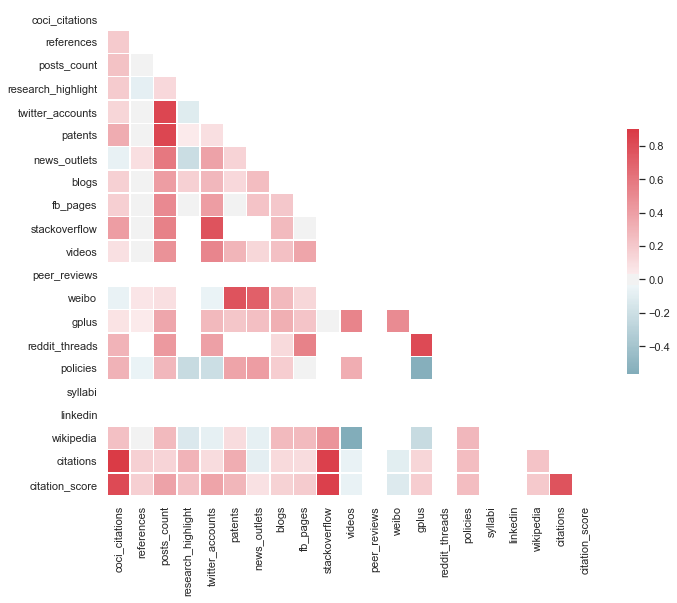

In [185]:
with sns.axes_style(style="white"):
    corr=metrics.corr(method="spearman")

    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Results

In [186]:
# Choose program to explore (TSCRP, NFRP, PCRP, PRORP)
selected_program = "PCRP"

results = articles.reset_index().merge(refs[refs.program==selected_program][['grant_id', 'reference']], left_on="reference", right_on="reference", how="inner")
results = results.merge(metrics, left_on="DOI", right_index=True)
len(results)

6401

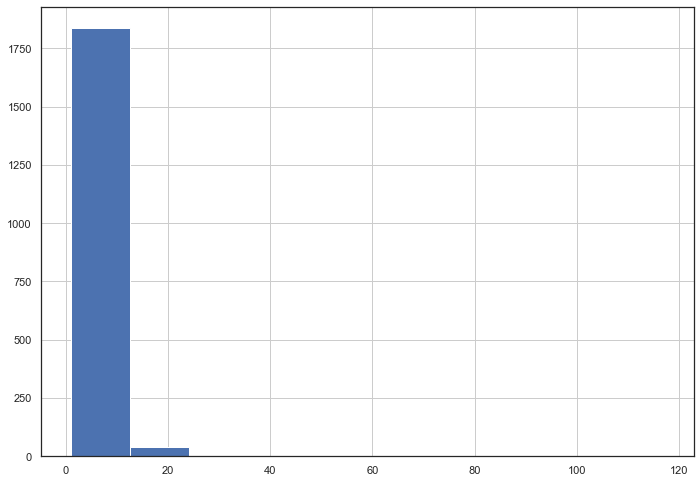

In [187]:
results.groupby("grant_id").size().hist()

In [188]:
mean_metrics = results.groupby("grant_id")[['citation_score', 'citations', 'fb_pages', 'twitter_accounts']].mean()

(0.0, 1200.0)

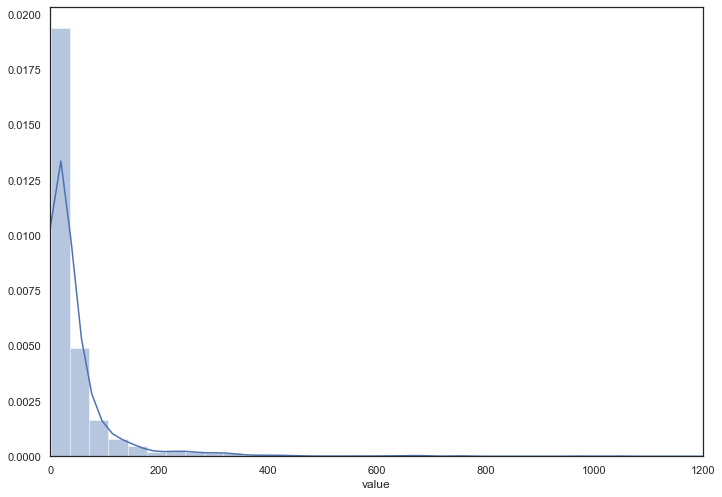

In [189]:
pdf = results.melt(id_vars="grant_id", value_vars="citations")
sns.distplot(pdf.value.dropna())
plt.xlim(0,1200)

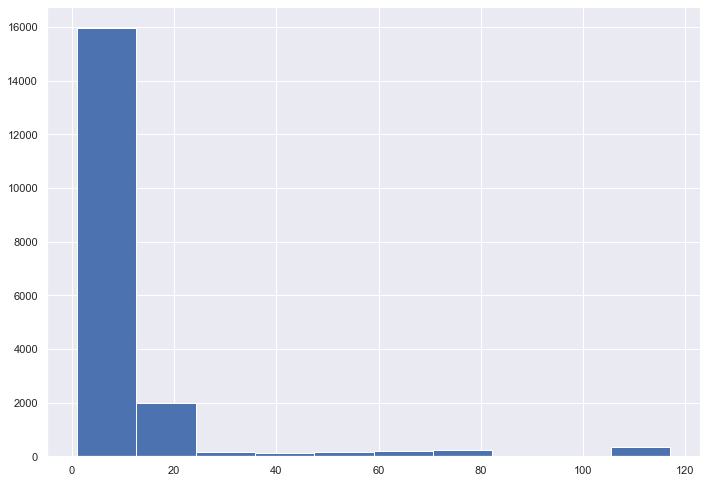

In [85]:
pdf = results.melt(id_vars=["grant_id", "citation_score"], value_vars=['citations', 'fb_pages', 'twitter_accounts'])
pdf = pdf.merge(results.groupby("grant_id").size().to_frame("articles"), left_on="grant_id", right_index=True)
pdf.articles.hist()

In [100]:
pdf.dropna()

,grant_id,citation_score,citations,fb_pages,twitter_accounts,articles
0,PC021004,1.388000,83.000000,1.000000,1.200000,117
1,PC030095,3.399000,86.000000,1.000000,3.000000,3
2,PC040160,1.458000,105.000000,1.000000,1.000000,4
3,PC040204,1.906333,54.666667,118.333333,22.666667,3
4,PC040238,1.007000,30.857143,1.000000,1.000000,23
...,...,...,...,...,...,...
200,PC161018,1.075000,2.666667,2.000000,26.500000,5
201,PC161019,6.498667,12.000000,1.000000,34.750000,4
202,PC161025,10.975500,17.500000,1.000000,36.333333,3
203,PC161026,2.509000,4.000000,1.000000,33.000000,3


In [113]:
results.citation_score = results.citation_score*100

In [115]:
results.citation_score.min()

2.5

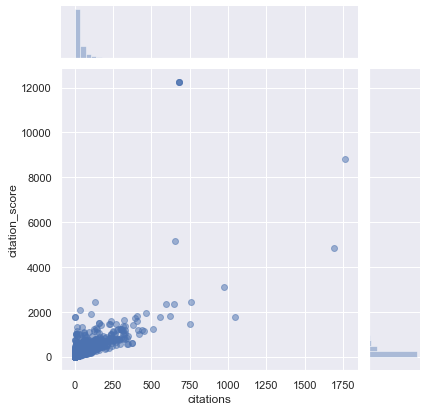

In [122]:
sns.jointplot(x="citations", y="citation_score", data=results, alpha=.5)


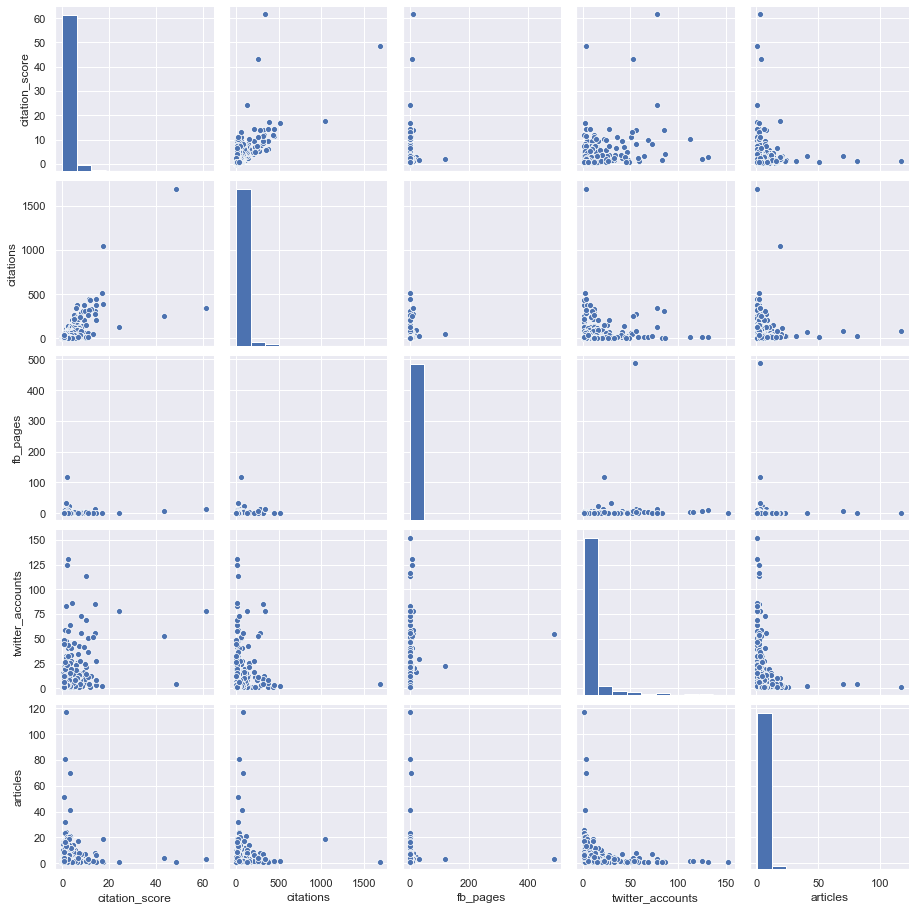

In [101]:
pdf = results.groupby("grant_id")[['citation_score', 'citations', 'fb_pages', 'twitter_accounts']].mean().reset_index()
pdf = pdf.merge(results.groupby("grant_id").size().to_frame("articles"), left_on="grant_id", right_index=True)
# pdf = pdf.melt(id_vars=["grant_id", "citation_score"], value_vars=['citations', 'fb_pages', 'twitter_accounts'], var_name="metric", value_name="count")
sns.pairplot(pdf)

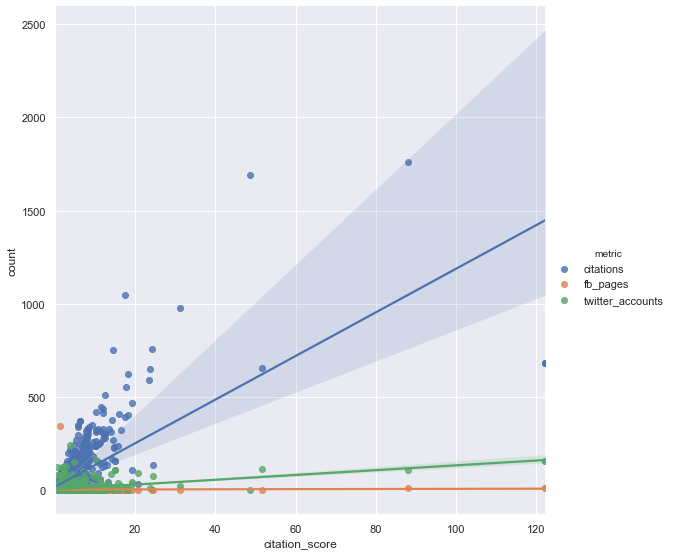

In [87]:
pdf = results.melt(id_vars=["grant_id", "citation_score"], value_vars=['citations', 'fb_pages', 'twitter_accounts'], var_name="metric", value_name="count")
pdf = pdf.merge(results.groupby("grant_id").size().to_frame("articles"), left_on="grant_id", right_index=True)
sns.lmplot(x="citation_score", y="count", hue="metric", data=pdf, scatter=True, height=8)
# plt.yscale("log")
# plt.xlim(0,15)
# plt.ylim(0,600)

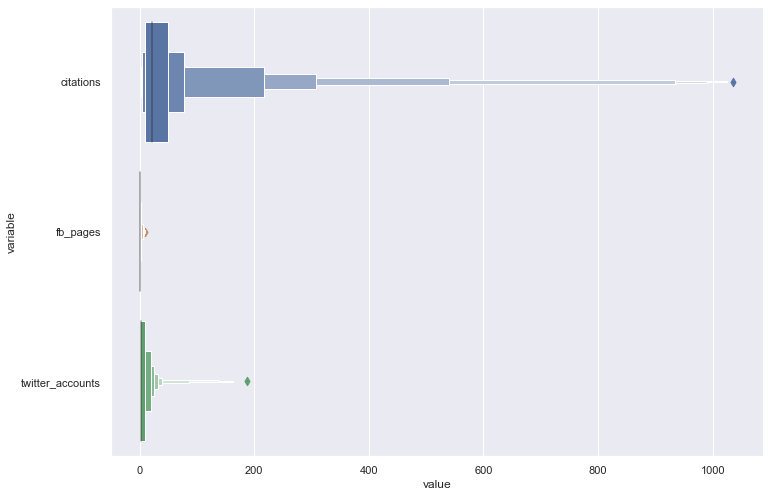

In [17]:
pdf = results.melt(id_vars="grant_id", value_vars=['citations', 'fb_pages', 'twitter_accounts'])
sns.boxenplot(y="variable", x="value", data=pdf)